<a href="https://colab.research.google.com/github/hafizbudi/active-learning/blob/main/AL_with_CrisisMMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/Project/multimodal_social_media

In [64]:
pip install modal

Note: you may need to restart the kernel to use updated packages.


In [126]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, metrics
from dataclasses import dataclass
import dataclasses

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from modAL.uncertainty import margin_sampling
from modAL.uncertainty import entropy_sampling

from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss

from sklearn.neighbors import KNeighborsClassifier
import time
import random

In [127]:
def random_sampling(classifier, X,
                     n_instances: int = 1, random_tie_break: bool = False):
    
    query_idx = np.random.choice(range(len(X)), size=n_instances, replace=False)
    
    return query_idx, X[query_idx]


In [157]:
@dataclass
class Experiment:
    n_samples: int
    repeat: int
    accuracy: float
    log_loss: float

# load the file
def load_data(filename, nb_instance, all_instance):
  n = all_instance #number of records in file
  s = nb_instance #sample size
  skip = sorted(random.sample(range(1,n+1),n-s))

  #df = pd.read_csv(filename,sep="\t",nrows=nb_instance)
  df = pd.read_csv(filename,sep="\t",skiprows=skip)

  df.label_image = pd.Categorical(df.label_image)
  df['label_image_code'] = df.label_image.cat.codes

  df[['image','label_image','label_image_code']]

  df.describe()
  return df

# read, resize and flatten into 1-dimension array
def pre_process_image(data):
  img_arr = []
  for index,row in data.iterrows():
    read_img = cv2.imread(row['image'],0)
    img_resize = cv2.resize(read_img,(224,224))
    img_ravel = img_resize.ravel()
    img_arr.append(img_ravel)

  img_np = np.array(img_arr)

  return img_np

# learning curve for active learning
def random_forest_score_repeat(n_initial,n_queries,sampling_strategy, repeats, seed):
  
  start_time = time.time()
  acc_all = []
  experiments = []
  
  # repeat as much as repeats parameter
  for k in tqdm(range(repeats)):
    print(k)
    np.random.seed(seed + k)
    i = n_initial[0]
    
    initial_idx = np.random.choice(range(len(X_train)), size=i, replace=False)
    print("Indexes for ",i,": ",initial_idx)
    X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]
    

    X_pool,y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)

    learner = ActiveLearner(
              estimator=LogisticRegression(max_iter=10000),
              #estimator=RandomForestClassifier(),
              query_strategy=sampling_strategy,
              X_training=X_initial,y_training=y_initial
              )
    acc = learner.score(X_test,y_test)
    #acc_all.append(acc)

    predictions = learner.predict_proba(X_test)
    res_logloss = log_loss(y_test,predictions)

    experiments.append(Experiment(n_samples=i, repeat=k, accuracy=acc,log_loss=res_logloss))
    
    for j in n_initial[1:]:

      query_idx, query_inst = learner.query(X_pool, n_queries)
      learner.teach(query_inst, y_pool[query_idx])
      X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)

      acc = learner.score(X_test,y_test)
      #acc_all.append(acc)
      predictions = learner.predict_proba(X_test)
      res_logloss = log_loss(y_test,predictions)
      experiments.append(Experiment(n_samples=j, repeat=k, accuracy=acc, log_loss=res_logloss))

    #predictions = learner.predict_proba(X_test)
    #res_logloss = log_loss(y_test,predictions)

    #experiments.append(Experiment(n_samples=j, repeat=k, accuracy=res_logloss))
    
    
  final_time = time.time() - start_time
  predictions = learner.predict(X_test)
  #predictions = learner.predict_proba(X_test)
  res_classification = classification_report(y_test, predictions)
  #res_classification = log_loss(y_test,predictions)

  print("--- %s seconds ---" % (final_time))

  return res_classification, acc_all, final_time, experiments

In [158]:
# Random sampling

# random selection from X train
def random_selection_learning(n_instances, X_train, y_train,i,seed):
    clf = LogisticRegression()
    np.random.seed(seed+i)
   

    initial_idx = np.random.choice(range(len(X_train)), size=n_instances, replace=False)
    print("Indexes for ",i,": ",initial_idx)
    
    X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]

    X_pool,y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)
    clf = RandomForestClassifier()
    clf.fit(X_initial, y_initial)

    return clf, X_initial, X_pool, y_initial, y_pool

def random_sampling_policy(model, n_new_samples, X_remaining, y_remaining):
    X_new_selected, X_remaining, y_new_selected, y_remaining = \
               train_test_split(X_remaining, y_remaining,  train_size=n_new_samples, shuffle=True)
    return X_new_selected, X_remaining, y_new_selected, y_remaining

# evaluate model performance
def evaluate(model, X_real, y_real):
    y_predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_real,y_predictions)
    
    return accuracy

def learning_curve(data_points, repeats, selection_policy, seed):
    start_time = time.time()
    experiments = []
    for i in tqdm(range(repeats)):
        #np.random.seed(seed+i)
        #np.random.seed(123)
        # First learn 
        n_samples = data_points[0]
        model, X_selected, X_remaining, y_selected, y_remaining = \
            random_selection_learning(n_samples, X_train, y_train,i,seed)

        predictions = model.predict_proba(X_test)
        res_logloss = log_loss(y_test,predictions)

        acc = evaluate(model, X_test, y_test)

        experiments.append(Experiment(n_samples=n_samples, repeat=i, accuracy=acc, log_loss=res_logloss))
        for n_samples in data_points[1:]:
            # Select the additional examples
            n_new_samples = n_samples - len(X_selected)
      
            X_new_selected, X_remaining, y_new_selected, y_remaining = \
                selection_policy(model, n_new_samples, X_remaining, y_remaining)
            
            X_selected = np.vstack((X_selected, X_new_selected))
            y_selected = np.hstack((y_selected, y_new_selected))
      
            model.fit(X_selected, y_selected)
           
            acc = evaluate(model, X_test, y_test)
            predictions = model.predict_proba(X_test)
            res_logloss = log_loss(y_test,predictions)

            experiments.append(Experiment(n_samples=n_samples, repeat=i, accuracy=acc, log_loss=res_logloss))
    final_time = time.time() - start_time

    predictions = model.predict(X_test)
    res_classification = classification_report(y_test, predictions)
    
    print("--- %s seconds ---" % (final_time))

    return experiments, res_classification, final_time

In [159]:
# Load CrisisMMD dataset

start_time = time.time()

#train_instance = 9601
#test_instance = 1534

all_train_instance = 9601
all_test_instance = 1534

# Use 10 % amount of data for initial phase
train_instance = 960
test_instance = 153

train_filename = "data/task_data/task_informative_text_img_agreed_lab_train.tsv"
test_filename = "data/task_data/task_informative_text_img_agreed_lab_test.tsv"

data_train = load_data(train_filename,train_instance, all_train_instance)
data_images_train = pre_process_image(data_train)

data_test = load_data(test_filename,test_instance, all_test_instance)
data_image_test = pre_process_image(data_test)

X_train = data_images_train.reshape(train_instance,-1)
y_train = data_train['label_image_code'].values

X_test = data_image_test.reshape(test_instance,-1)
y_test = data_test['label_image_code'].values

final_time = time.time() - start_time
print("--- %s seconds ---" % (final_time))

FileNotFoundError: [Errno 2] No such file or directory: 'data/task_data/task_informative_text_img_agreed_lab_train.tsv'

In [160]:
# Load Digits dataset

digits = load_digits()
n = len(digits.images)
np.random.seed(123)

X = digits.images.reshape(n,-1)
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25,shuffle=True)

Train data distribution
Not Informative  140
Informative  127


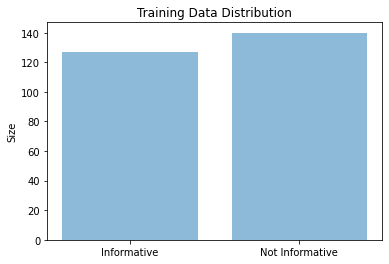

In [161]:
# Show plot for train data distribution

print("Train data distribution")

notinf_y_train = y_train[y_train == 1]
len_notinf = len(notinf_y_train)
print("Not Informative ",len_notinf)

inf_y_train = y_train[y_train == 0]
len_inf = len(inf_y_train)
print("Informative ",len_inf)

labels = ('Informative','Not Informative')
y_pos = np.arange(len(labels))

size = [len_inf,len_notinf]
plt.bar(y_pos,size,align='center',alpha=0.5)
plt.xticks(y_pos,labels)
plt.ylabel('Size')
plt.title('Training Data Distribution')

plt.show()

Test data distribution
Not Informative  42
Informative  51


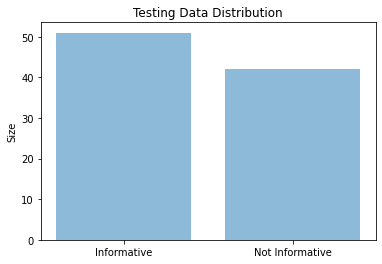

In [162]:
# Show plot for test data distribution

print("Test data distribution")

notinf_y_test = y_test[y_test == 1]
len_notinf_test = len(notinf_y_test)
print("Not Informative ",len_notinf_test)

inf_y_test = y_test[y_test == 0]
len_inf_test = len(inf_y_test)
print("Informative ",len_inf_test)

labels = ('Informative','Not Informative')
y_pos = np.arange(len(labels))

size = [len_inf_test,len_notinf_test]
plt.bar(y_pos,size,align='center',alpha=0.5)
plt.xticks(y_pos,labels)
plt.ylabel('Size')
plt.title('Testing Data Distribution')

plt.show()

In [163]:
n_initial = range(30,300,30)
n_queries = 30 # number of query for uncertain dataset to be asked
repeats = 3 # number of repeat for each n_initial
seed = 20 # random seed

In [164]:
result_rf_uncertainty, result_rf_acc_uncertainty, result_rf_time_uncertainty, experiment_uncertainty = random_forest_score_repeat(n_initial,n_queries,uncertainty_sampling,repeats,seed)
print(experiment_uncertainty)


  0%|          | 0/3 [00:00<?, ?it/s]

0
Indexes for  30 :  [1042  709  560  659  650 1051  121   61  640  467  941  450  410  889
  855  589  921  244  926  665  806 1152  915  682  359   58  337  313
  890  155]


 33%|███▎      | 1/3 [00:04<00:09,  4.81s/it]

1
Indexes for  30 :  [ 602 1246  801  277  323  478  711  146  794  401  103  632  627 1020
  714  911 1142   41  947 1113  300  698  427 1254  851 1195 1301  812
 1283  599]


 67%|██████▋   | 2/3 [00:10<00:05,  5.37s/it]

2
Indexes for  30 :  [1054  363  889 1341  478  646 1239   97  890  766  476  769  392  533
  466 1278  953  905 1125 1162  578  589  386  560  659  797  475 1231
 1204 1329]


100%|██████████| 3/3 [00:14<00:00,  4.79s/it]

--- 14.359219789505005 seconds ---
[Experiment(n_samples=30, repeat=0, accuracy=0.6866666666666666, log_loss=1.169624916342977), Experiment(n_samples=60, repeat=0, accuracy=0.8222222222222222, log_loss=0.6678407877237293), Experiment(n_samples=90, repeat=0, accuracy=0.8844444444444445, log_loss=0.3700150350570363), Experiment(n_samples=120, repeat=0, accuracy=0.9044444444444445, log_loss=0.32722105537467505), Experiment(n_samples=150, repeat=0, accuracy=0.9222222222222223, log_loss=0.3069630550352264), Experiment(n_samples=180, repeat=0, accuracy=0.9311111111111111, log_loss=0.245698845692331), Experiment(n_samples=210, repeat=0, accuracy=0.9377777777777778, log_loss=0.207049731703564), Experiment(n_samples=240, repeat=0, accuracy=0.9533333333333334, log_loss=0.15883548755842566), Experiment(n_samples=270, repeat=0, accuracy=0.9555555555555556, log_loss=0.17163068661894715), Experiment(n_samples=30, repeat=1, accuracy=0.6888888888888889, log_loss=1.0462963817147863), Experiment(n_sampl

In [ ]:
result_rf_margin, result_rf_acc_margin, result_rf_time_margin, experiment_margin = random_forest_score_repeat(n_initial,n_queries,margin_sampling,repeats, seed)
print(experiment_margin)

  0%|          | 0/3 [00:00<?, ?it/s]

0
Indexes for  30 :  [1042  709  560  659  650 1051  121   61  640  467  941  450  410  889
  855  589  921  244  926  665  806 1152  915  682  359   58  337  313
  890  155]


 33%|███▎      | 1/3 [00:04<00:09,  4.62s/it]

1
Indexes for  30 :  [ 602 1246  801  277  323  478  711  146  794  401  103  632  627 1020
  714  911 1142   41  947 1113  300  698  427 1254  851 1195 1301  812
 1283  599]


 67%|██████▋   | 2/3 [00:08<00:04,  4.30s/it]

2
Indexes for  30 :  [1054  363  889 1341  478  646 1239   97  890  766  476  769  392  533
  466 1278  953  905 1125 1162  578  589  386  560  659  797  475 1231
 1204 1329]


In [ ]:
result_rf_entropy, result_rf_acc_entropy, result_rf_time_entropy, experiment_entropy = random_forest_score_repeat(n_initial,n_queries,entropy_sampling,repeats, seed)
print(experiment_entropy)

In [ ]:
n_initial = range(30,300,30)
seed_random = 20 # random seed
repeat_random = 3 # number of repeat for each n_initial
#experiment_random, res_random, time_random = learning_curve(n_initial, repeat_random, random_sampling_policy,seed_random)
result_rf_random, result_rf_acc_random, result_rf_time_random, experiment_random = random_forest_score_repeat(n_initial,n_queries,random_sampling,repeats, seed)

In [ ]:
# show accuracy and log loss for each n_sample and repeat

print(experiment_uncertainty)
print(experiment_margin)
print(experiment_entropy)
print(experiment_random)

In [ ]:
# show accuracy plot

def plot_learning_curve(df, name):
    # Compute percentiles
    p10 = df.groupby('n_samples').quantile(.10)['accuracy']
    p50 = df.groupby('n_samples').median()['accuracy']
    p90 = df.groupby('n_samples').quantile(.90)['accuracy']
    training_sizes= p50.index.to_numpy()

    with plt.style.context('seaborn-white'):
        plt.title('Active Learning vs Random Sampling Crisis MMD')
        plt.plot(training_sizes, p50, label=name )

        # show standard deviation
        plt.fill_between(training_sizes, p10, p90,alpha=0.1)
    plt.legend(loc='lower right')
    plt.xlabel("Number of sample")
    plt.ylabel("Accuracy")
    plt.grid()
    #plt.show()

df_us = pd.DataFrame([dataclasses.asdict(e) for e in experiment_uncertainty])
df_ms = pd.DataFrame([dataclasses.asdict(e) for e in experiment_margin])
df_es = pd.DataFrame([dataclasses.asdict(e) for e in experiment_entropy])
df_rs = pd.DataFrame([dataclasses.asdict(e) for e in experiment_random])
plot_learning_curve(df_us, "Uncertainty")
plot_learning_curve(df_ms, "Margin")
plot_learning_curve(df_es, "Entropy")
plot_learning_curve(df_rs, "Random")

In [ ]:
# show log loss plot

def plot_learning_curve(df, name):
    # Compute percentiles
    p10 = df.groupby('n_samples').quantile(.10)['log_loss']
    p50 = df.groupby('n_samples').median()['log_loss']
    p90 = df.groupby('n_samples').quantile(.90)['log_loss']
    training_sizes= p50.index.to_numpy()

    with plt.style.context('seaborn-white'):
        plt.title('Active Learning vs Random Sampling Crisis MMD')
        plt.plot(training_sizes, p50, label=name )

        # show standard deviation
        plt.fill_between(training_sizes, p10, p90,alpha=0.1)
    plt.legend(loc='upper right')
    plt.xlabel("Number of sample")
    plt.ylabel("Log Loss")
    plt.grid()
    #plt.show()

df_us = pd.DataFrame([dataclasses.asdict(e) for e in experiment_uncertainty])
df_ms = pd.DataFrame([dataclasses.asdict(e) for e in experiment_margin])
df_es = pd.DataFrame([dataclasses.asdict(e) for e in experiment_entropy])
df_rs = pd.DataFrame([dataclasses.asdict(e) for e in experiment_random])
plot_learning_curve(df_us, "Uncertainty")
plot_learning_curve(df_ms, "Margin")
plot_learning_curve(df_es, "Entropy")
plot_learning_curve(df_rs, "Random")

In [ ]:
# show precision, recall, f-1 score for final n_sample active learning

print(result_rf_uncertainty)
print(result_rf_margin)
print(result_rf_entropy)

print(result_rf_time_uncertainty)
print(result_rf_time_margin)
print(result_rf_time_entropy)

In [16]:
# show precision, recall, f-1 score for final n_sample random sampling

print(res_random)
print(time_random)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        51
           1       0.82      0.98      0.89        42
           2       1.00      0.80      0.89        41
           3       0.83      0.97      0.90        40
           4       0.98      0.94      0.96        52
           5       1.00      0.79      0.88        48
           6       0.98      0.98      0.98        48
           7       0.89      1.00      0.94        41
           8       0.88      0.82      0.85        45
           9       0.77      0.81      0.79        42

    accuracy                           0.91       450
   macro avg       0.91      0.91      0.91       450
weighted avg       0.92      0.91      0.91       450

4.637619972229004
